# Classyfing names with Character Level RNN
In this notebook we will use pytorch to classify names using character level RNN.<br>
The puropose of this tutorial is to get familiar with simple RNN architecture 
and it's implementation in 
pytorch.<br>
This tutorial follow this tutorial : https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import torch 

from __future__ import unicode_literals, print_function, division
from io import open
from glob import glob
import os

import unicodedata
import string

## Data Prepration

### Data Utils
In the next cell we will define some variables and function which will help
process the text. <br>
You can find the data here : [DATA](https://download.pytorch.org/tutorial/data.zip)

In [6]:
def find_files(path): return glob(path)

print(find_files('data/names/*.txt'))

all_letters = string.ascii_letters + ".,;"
n_letters = len(all_letters)

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

['data/names/Irish.txt', 'data/names/French.txt', 'data/names/Korean.txt', 'data/names/Japanese.txt', 'data/names/Portuguese.txt', 'data/names/Italian.txt', 'data/names/Chinese.txt', 'data/names/Russian.txt', 'data/names/Polish.txt', 'data/names/German.txt', 'data/names/Scottish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Dutch.txt', 'data/names/Arabic.txt', 'data/names/Vietnamese.txt', 'data/names/Czech.txt', 'data/names/Greek.txt']


### Load Data
We will store the data in a simple python dictionary. <br>
The language will serve as the key, and the value of each language is all the names in that language.

In [7]:
category_lines = {} # A dictionay with key=language, value=lines of names in the language.
all_categories = []

for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0] # Extrach the language name.
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

Lets see the data makes sense. 

In [8]:
np.random.seed(4300)
random_language = np.random.choice(all_categories) # Pick a random language
print(category_lines[random_language][:5], random_language) # Print 5 names from the language.

['Ababko', 'Abaev', 'Abagyan', 'Abaidulin', 'Abaidullin'] Russian


### Tensors Conversion
The next thing we want to do is convert our data into numeric data.<br>
Remeber this is a char based RNN so we need to find a representation for each letter.<br>
As we are trainig a deep learining model with pytorch we will convert the data into tensors, and more specifically a one hot encdoing tensors. So each letter turns into into a vector of size n_letters with zero everywhere except the index of the letter.<br>
Pytorch models expect the following structure as input : [batch_size, channels, length]


In [34]:
# Util function to find the letter index.
def letter_to_index(l):
    return all_letters.find(l)

def letter_to_tensor(l):
    tensor = torch.zeros(1, n_letters)
    l_index = letter_to_index(l)
    tensor[0][l_index] = 1
    return tensor

# Converts a line in our data (string) into a one hot encdoing tensor.
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = letter_to_index(letter)
        tensor[li][0][letter_index] = 1
        
    return tensor

## Model


In [95]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
    
        self.hidden_size = hidden_size
        
        # i2h = Input to Hidden
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        
        # i2i = Input to Output
        self.i20 = nn.Linear(input_size+hidden_size, output_size)
        
        # Activation
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, net_input, net_hidden):
        # Concatanated input
        c_input = torch.cat((net_input, net_hidden), 1)
        
        # Forward
        hidden = self.i2h(c_input)
        output = self.i20(c_input)
        output = self.log_softmax(output)
        
        return output, hidden
    

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

### Here is an example of how to "use" the network with a single letter

In [96]:
net_input = letter_to_tensor('A')
net_hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(net_input, net_hidden)

## Training preparation

In [97]:
def get_language_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    
    return all_categories[category_i], category_i

# Let's check it out
print(get_language_from_output(output))

('Czech', 16)


In [98]:
def random_training_example():
    language = np.random.choice(all_categories)
    line = np.random.choice(category_lines[language])
    
    language_tensor = torch.tensor([all_categories.index(language)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return language, line, language_tensor, line_tensor

# Let's check it out II
for i in range(5):
    language, line, a, _ = random_training_example()
    print(language, line, a)

French Parris tensor([1])
Spanish Bengochea tensor([12])
German Voigt tensor([9])
Irish OHara tensor([0])
Chinese Ming tensor([6])


## Loss Function
We will use the negative log likelihood as our loss function. This loss is a good choice whenever you have 
softmax layer as your last layer (as it porvices you with a distribution), and since we are using log softmax we are using the log version of the likelihood. This helps with numerical stability. The reason it is negative is because we want to use gradient descent. 

In [109]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

# Training!

In [100]:
def train(language_tensor, line_tensor):
    hidden =torch.zeros(1, n_hidden)
    

    optimizer.zero_grad()
    
    line_len = line_tensor.size()[0]
    
    for i in range(line_len):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, language_tensor)
    loss.backward()
    
    optimizer.step()
    
    return output, loss.item()

In [110]:
import time
import math

n_iters     = 200000
print_every = 5000
plot_every  = 1000

current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    lng, line, lng_tensor, line_tensor = random_training_example()
    output, loss = train(lng_tensor, line_tensor)
    
    current_loss += loss
    if (iter % print_every) == 0:
        lng_p, lng_i = get_language_from_output(output)
        print("iter :{} True:{} Predicted:{} On:{}".format(iter, lng, lng_p, line))
    
    if (iter % plot_every) == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
    

iter :5000 True:Dutch Predicted:Dutch On:Pennders
iter :10000 True:Spanish Predicted:Spanish On:Escarcega
iter :15000 True:Irish Predicted:English On:Whelan
iter :20000 True:German Predicted:Irish On:Friedrich
iter :25000 True:French Predicted:French On:Sargent
iter :30000 True:Arabic Predicted:Greek On:Sarkis
iter :35000 True:French Predicted:French On:Sauvageot
iter :40000 True:Polish Predicted:Polish On:Dubanowski
iter :45000 True:Dutch Predicted:Dutch On:Muyskens
iter :50000 True:Irish Predicted:Irish On:OKane
iter :55000 True:German Predicted:Dutch On:Beckert
iter :60000 True:Spanish Predicted:Italian On:Maradona
iter :65000 True:Chinese Predicted:Chinese On:Foong
iter :70000 True:German Predicted:Greek On:Loris
iter :75000 True:Japanese Predicted:Japanese On:Hamaguchi
iter :80000 True:Arabic Predicted:Arabic On:Malouf
iter :85000 True:Portuguese Predicted:Portuguese On:Madeira
iter :90000 True:Vietnamese Predicted:Korean On:Kim
iter :95000 True:Spanish Predicted:Portuguese On:Riv

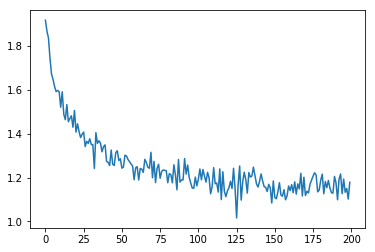

In [111]:
plt.plot(all_losses)

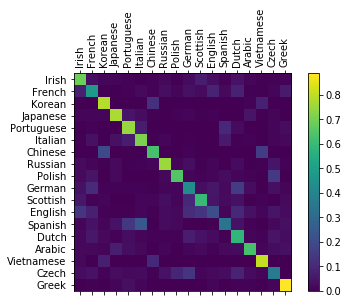

In [112]:
import matplotlib.ticker as ticker


# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = torch.zeros(1, n_hidden)

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_example()
    output = evaluate(line_tensor)
    guess, guess_i = get_language_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()